In [1]:
%load_ext autoreload
%autoreload 2

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
from jax import config

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"

In [3]:
import time
from itertools import chain
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pickle
import jax.numpy as jnp
from jax import jit, vmap, value_and_grad, lax
from jax.tree_util import tree_map
import jax
import jaxlib
import pandas as pd
import optax
from itertools import chain

import jaxley as jx
from jaxley.channels import Leak
from jaxley_mech.channels.l5pc import *
from jaxley.optimize.utils import l2_norm

In [4]:
print(f"jax {jax.__version__}")
print(f"jaxlib {jaxlib.__version__}")
print(f"pandas {pd.__version__}")
print(f"optax {optax.__version__}")
print(f"numpy {np.__version__}")

jax 0.4.26
jaxlib 0.4.26
pandas 2.2.1
optax 0.2.2
numpy 1.26.4


In [5]:
def sample_within(n, bounds):
    return jnp.asarray(np.random.rand(n) * (bounds[1] - bounds[0]) + bounds[0])

In [6]:
bounds = {}
gt_apical = {}
gt_soma = {}
gt_axon = {}

bounds["apical_NaTs2T_gNaTs2T"] = [0, 0.04]
gt_apical["apical_NaTs2T_gNaTs2T"] = 0.026145

bounds["apical_SKv3_1_gSKv3_1"] = [0, 0.04]
gt_apical["apical_SKv3_1_gSKv3_1"] = 0.004226

bounds["apical_M_gM"] = [0, 0.001]
gt_apical["apical_M_gM"] = 0.000143

bounds["somatic_NaTs2T_gNaTs2T"] = [0.0, 1.0]
gt_soma["somatic_NaTs2T_gNaTs2T"] = 0.983955

bounds["somatic_SKv3_1_gSKv3_1"] = [0.25, 1]
gt_soma["somatic_SKv3_1_gSKv3_1"] = 0.303472

bounds["somatic_SKE2_gSKE2"] = [0, 0.1]
gt_soma["somatic_SKE2_gSKE2"] = 0.008407

bounds["somatic_CaPump_gamma"] = [0.0005,0.01]
gt_soma["somatic_CaPump_gamma"] = 0.000609

bounds["somatic_CaPump_decay"] = [20, 1_000]
gt_soma["somatic_CaPump_decay"] = 210.485291

bounds["somatic_CaHVA_gCaHVA"] = [0, 0.001]
gt_soma["somatic_CaHVA_gCaHVA"] = 0.000994

bounds["somatic_CaLVA_gCaLVA"] = [0, 0.01]
gt_soma["somatic_CaLVA_gCaLVA"] = 0.000333

bounds["axonal_NapEt2_gNapEt2"] = [0.0, 1e-8]  # 4.0
gt_axon["axonal_NapEt2_gNapEt2"] = 0.006827

bounds["axonal_NaTaT_gNaTaT"] = [0.0, 4.0]
gt_axon["axonal_NaTaT_gNaTaT"] = 3.137968

bounds["axonal_KPst_gKPst"] = [0.0, 1.0]
gt_axon["axonal_KPst_gKPst"] = 0.973538

bounds["axonal_KTst_gKTst"] = [0.0, 0.1]
gt_axon["axonal_KTst_gKTst"] = 0.089259

bounds["axonal_SKE2_gSKE2"] = [0.0, 0.1]
gt_axon["axonal_SKE2_gSKE2"] = 0.007104

bounds["axonal_SKv3_1_gSKv3_1"] = [0.0, 2.0]  # [0, 2.0]
gt_axon["axonal_SKv3_1_gSKv3_1"] = 1.021945

bounds["axonal_CaHVA_gCaHVA"] = [0, 0.001]  # 0.001
gt_axon["axonal_CaHVA_gCaHVA"] = 0.00099

bounds["axonal_CaLVA_gCaLVA"] = [0, 0.01]  # 0.01
gt_axon["axonal_CaLVA_gCaLVA"] = 0.008752

bounds["axonal_CaPump_gamma"] = [0.0005, 0.05]  # [0.0005,0.05]
gt_axon["axonal_CaPump_gamma"] = 0.00291

bounds["axonal_CaPump_decay"] = [20, 1_000]
gt_axon["axonal_CaPump_decay"] = 287.19873

In [7]:
nseg = 4
cell = jx.read_swc("../morphologies/bbp_with_axon.swc", nseg=nseg, max_branch_len=300.0, assign_groups=True)

soma_inds = np.unique(cell.group_nodes["soma"].branch_index).tolist()
apical_inds = np.unique(cell.group_nodes["apical"].branch_index).tolist()
basal_inds = np.unique(cell.group_nodes["basal"].branch_index).tolist()
axonal_inds = np.unique(cell.group_nodes["axon"].branch_index).tolist()

########## APICAL ##########
cell.apical.set("capacitance", 2.0)
cell.apical.insert(NaTs2T().change_name("apical_NaTs2T"))
cell.apical.insert(SKv3_1().change_name("apical_SKv3_1"))
cell.apical.insert(M().change_name("apical_M"))
cell.apical.insert(H().change_name("apical_H"))
for b in apical_inds:
    for c in [0.125, 0.375, 0.625, 0.875]:
        distance = cell.branch(b).loc(c).distance(cell.branch(0).loc(0.0))
        cond = (-0.8696 + 2.087* np.exp(distance*0.0031)) * 8e-5
        cell.branch(b).loc(c).set("apical_H_gH", cond)

########## SOMA ##########
cell.soma.insert(NaTs2T().change_name("somatic_NaTs2T"))
cell.soma.insert(SKv3_1().change_name("somatic_SKv3_1"))
cell.soma.insert(SKE2().change_name("somatic_SKE2"))
ca_dynamics = CaNernstReversal()
ca_dynamics.channel_constants["T"] = 307.15
cell.soma.insert(ca_dynamics)
cell.soma.insert(CaPump().change_name("somatic_CaPump"))
cell.soma.insert(CaHVA().change_name("somatic_CaHVA"))
cell.soma.insert(CaLVA().change_name("somatic_CaLVA"))
cell.soma.set("CaCon_i", 5e-05)
cell.soma.set("CaCon_e", 2.0)

########## BASAL ##########
cell.basal.insert(H().change_name("basal_H"))
cell.basal.set("basal_H_gH", 8e-5)

# ########## AXON ##########
cell.insert(CaNernstReversal())
cell.set("CaCon_i", 5e-05)
cell.set("CaCon_e", 2.0)

cell.axon.insert(NaTaT().change_name("axonal_NaTaT"))
cell.axon.set("axonal_NaTaT_gNaTaT", 3.137968)

cell.axon.insert(KTst().change_name("axonal_KTst"))
cell.axon.set("axonal_KTst_gKTst", 0.089259)

cell.axon.insert(CaPump().change_name("axonal_CaPump"))
cell.axon.set("axonal_CaPump_gamma", 0.00291)
cell.axon.set("axonal_CaPump_decay", 287.19873)

cell.axon.insert(NapEt2().change_name("axonal_NapEt2"))
cell.axon.set("axonal_NapEt2_gNapEt2", 0.006827)

cell.axon.insert(SKE2().change_name("axonal_SKE2"))
cell.axon.set("axonal_SKE2_gSKE2", 0.007104)

cell.axon.insert(CaHVA().change_name("axonal_CaHVA"))
cell.axon.set("axonal_CaHVA_gCaHVA", 0.00099)

cell.axon.insert(KPst().change_name("axonal_KPst"))
cell.axon.set("axonal_KPst_gKPst", 0.973538)

cell.axon.insert(SKv3_1().change_name("axonal_SKv3_1"))
cell.axon.set("axonal_SKv3_1_gSKv3_1", 1.021945)

cell.axon.insert(CaLVA().change_name("axonal_CaLVA"))
cell.axon.set("axonal_CaLVA_gCaLVA", 0.008752)


########## WHOLE CELL  ##########
cell.insert(Leak())
cell.set("Leak_gLeak", 3e-05)
cell.set("Leak_eLeak", -75.0)

cell.set("axial_resistivity", 100.0)
cell.set("eNa", 50.0)
cell.set("eK", -85.0)
cell.set("v", -65.0)

In [8]:
res = 100
sigma = 400

evals = np.linspace(0, 1200, res)
kernel = np.zeros((res, res))
for ind_i, i in enumerate(evals):
    for ind_j, j in enumerate(evals):
        d = (i - j)**2
        kernel[ind_i, ind_j] = np.exp(-d / sigma**2)

def softplus(x):
    return np.log(1 + np.exp(x))

def inv_softplus(x: jnp.ndarray):
    """Inverse softplus."""
    return np.log(np.exp(x) - 1)

def sigmoid(x: jnp.ndarray) -> jnp.ndarray:
    """Sigmoid."""
    return 1 / (1 + jnp.exp(-1.5*x))

def expit(x: jnp.ndarray) -> jnp.ndarray:
    """Inverse sigmoid (expit)"""
    return -jnp.log(1 / x - 1)

def gaussian_cdf(x):
    return jax.scipy.stats.norm.cdf(x)

def sample_profile():
    profile = np.random.multivariate_normal(np.zeros((res)), kernel)
    return gaussian_cdf(profile)  # Times 1.2 s.t. mean is roughly 1.0

# For every parameter, sample the ground truth parameter function.
np.random.seed(2)
gt_profiles_apical = {}
gt_profiles_apical["apical_NaTs2T_gNaTs2T"] = sample_profile()
gt_profiles_apical["apical_SKv3_1_gSKv3_1"] = sample_profile()
gt_profiles_apical["apical_M_gM"] = sample_profile()

gt_profiles_axonal = {}
gt_profiles_axonal["axonal_NapEt2_gNapEt2"] = sample_profile()
gt_profiles_axonal["axonal_NaTaT_gNaTaT"] = sample_profile()
gt_profiles_axonal["axonal_KPst_gKPst"] = sample_profile()
gt_profiles_axonal["axonal_KTst_gKTst"] = sample_profile()
gt_profiles_axonal["axonal_SKE2_gSKE2"] = sample_profile()
gt_profiles_axonal["axonal_SKv3_1_gSKv3_1"] = sample_profile()
gt_profiles_axonal["axonal_CaHVA_gCaHVA"] = sample_profile()
gt_profiles_axonal["axonal_CaLVA_gCaLVA"] = sample_profile()

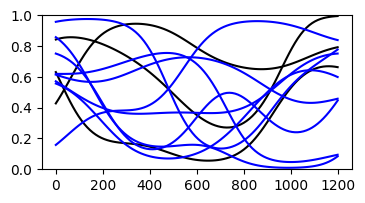

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
counter = 0
for item in gt_profiles_apical.values():
    if counter < 3:
        _ = ax.plot(evals, item, c="k")
    counter += 1
for item in gt_profiles_axonal.values():
    _ = ax.plot(evals, item, c="b")
_ = ax.set_ylim([0, 1])
plt.show()

In [10]:
# Apical.
for b in apical_inds:
    distance = cell.branch(b).loc(0.0).distance(cell.branch(0).loc(0.0))
    for key, item in gt_profiles_apical.items():
        cond = np.interp(distance, evals, item)
        cell.branch(b).set(key, cond * bounds[key][1])

for key in gt_soma.keys():
    cell.soma.set(key, gt_soma[key])

for b in axonal_inds:
    distance = cell.branch(b).loc(0.0).distance(cell.branch(0).loc(0.0))
    for key, item in gt_profiles_axonal.items():
        cond = np.interp(distance, evals, item)
        cell.branch(b).set(key, cond * bounds[key][1])

for key in gt_axon.keys():
    cell.axon.set(key, gt_axon[key])

In [11]:
cell.delete_trainables()

for key in gt_profiles_apical.keys():
    cell.branch(apical_inds).make_trainable(key)

for key in gt_soma.keys():
    cell.soma.make_trainable(key)

for key in gt_profiles_axonal.keys():
    cell.branch(axonal_inds).make_trainable(key)

cell.axon.make_trainable("axonal_CaPump_gamma")
cell.axon.make_trainable("axonal_CaPump_decay")

parameters = cell.get_parameters()

Number of newly added trainable parameters: 129. Total number of trainable parameters: 129
Number of newly added trainable parameters: 129. Total number of trainable parameters: 258
Number of newly added trainable parameters: 129. Total number of trainable parameters: 387
Number of newly added trainable parameters: 1. Total number of trainable parameters: 388
Number of newly added trainable parameters: 1. Total number of trainable parameters: 389
Number of newly added trainable parameters: 1. Total number of trainable parameters: 390
Number of newly added trainable parameters: 1. Total number of trainable parameters: 391
Number of newly added trainable parameters: 1. Total number of trainable parameters: 392
Number of newly added trainable parameters: 1. Total number of trainable parameters: 393
Number of newly added trainable parameters: 1. Total number of trainable parameters: 394
Number of newly added trainable parameters: 142. Total number of trainable parameters: 536
Number of new

In [12]:
repeats = {
    "apical_NaTs2T_gNaTs2T": len(apical_inds),
    "apical_SKv3_1_gSKv3_1": len(apical_inds),
    "apical_M_gM": len(apical_inds), 
    "somatic_NaTs2T_gNaTs2T": 1,
    "somatic_SKv3_1_gSKv3_1": 1,
    "somatic_SKE2_gSKE2": 1,
    "somatic_CaHVA_gCaHVA": 1,
    "somatic_CaLVA_gCaLVA": 1,
    "somatic_CaPump_gamma": 1,
    "somatic_CaPump_decay": 1,
    "axonal_NapEt2_gNapEt2": len(axonal_inds),
    "axonal_NaTaT_gNaTaT": len(axonal_inds),
    "axonal_KPst_gKPst": len(axonal_inds),
    "axonal_KTst_gKTst": len(axonal_inds),
    "axonal_SKE2_gSKE2": len(axonal_inds),
    "axonal_SKv3_1_gSKv3_1": len(axonal_inds),
    "axonal_CaHVA_gCaHVA": len(axonal_inds),
    "axonal_CaLVA_gCaLVA": len(axonal_inds),
    "axonal_CaPump_gamma": 1,
    "axonal_CaPump_decay": 1,
}
num_params = sum(list(repeats.values()))
print(f"Total number of parameters: {num_params}")

Total number of parameters: 1532


In [13]:
dt = 0.025
t_max = 5.0
time_vec = np.arange(0, t_max+2*dt, dt)

cell.delete_stimuli()
cell.delete_recordings()

i_delay = 0.0
i_dur = 3.0
i_amp = 3.0
current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)
cell.branch(soma_inds[0]).loc(0.0).stimulate(current)  # Stimulate soma
cell[range(0,339,1),0].record()

cell.set("v", -70.0)
cell.init_states()

Added 1 stimuli. See `.currents` for details.
Added 339 recordings. See `.recordings` for details.


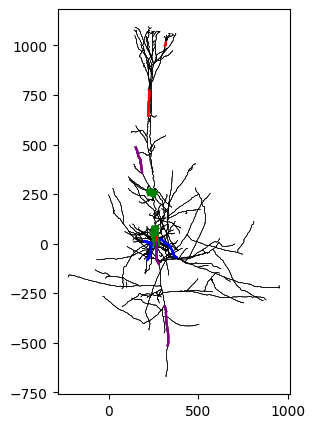

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(3, 5))
_ = cell.vis(ax=ax, morph_plot_kwargs={"linewidth": 0.3})
_ = cell[[13, 215, 230]].vis(ax=ax, col="g", morph_plot_kwargs={"linewidth": 5.0})  # Proximal apical
_ = cell[[1, 270, 290]].vis(ax=ax, col="r")  # Distal apical
_ = cell[[165, 170, 185]].vis(ax=ax, col="b")  # Basal
_ = cell[[2, 53, 93]].vis(ax=ax, col="purple")  # Basal
plt.show()

In [15]:
def simulate(params):
    return jx.integrate(cell, params=params)

jitted_sim = jit(simulate)
vmapped_sim = jit(vmap(simulate, in_axes=(0,)))

def sim_gt():
    return jx.integrate(cell)

jitted_sim_gt = jit(sim_gt)

In [16]:
blues = [
    "#74a9cf",
    "#3690c0",
    "#0570b0",
]
reds = [
    "#fc8d59",
    "#ef6548",
    "#d7301f",
]
greens = [
    "#66c2a4",
    "#41ae76",
    "#238b45",
]
grays = [
    "#969696",
    "#737373",
    "#525252",
]
cols = greens + reds + blues + grays

### Seed 0

findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, san

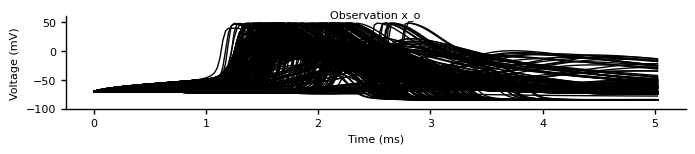

In [17]:
x_o = jitted_sim_gt()
    
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(8, 1.2))
    for i in range(len(x_o)):
        _ = ax.plot(time_vec, x_o[i], c="k")  #, c=cols[i])
    _ = ax.set_ylim([-100, 60])
    _ = ax.set_title(f"Observation x_o", y=0.9)
    _ = ax.set_xlabel("Time (ms)")
    _ = ax.set_ylabel("Voltage (mV)")
    # plt.savefig("results/figs/observation.png", dpi=300, bbox_inches="tight")
    plt.show()

### Define loss

In [18]:
def loss_from_v(v):
    return jnp.mean(jnp.abs(v[:, 40:200:5] - x_o[:, 40:200:5]))

vmapped_loss_from_v = vmap(loss_from_v, in_axes=(0,))

In [19]:
def build_regularizer(inds):
    parents = cell.comb_parents
    apical_inds_from_zero = np.arange(len(inds))
    
    parents_of_apical = np.asarray(parents)[np.asarray(inds)]
    parent_is_also_apical = np.asarray([p in np.asarray(inds) for p in parents_of_apical])
    apical_inds_from_zero = apical_inds_from_zero[parent_is_also_apical]
    
    parents_of_apical = parents_of_apical[parent_is_also_apical]
    parents_from_zero = np.asarray([np.where(inds == p)[0][0] for p in parents_of_apical])
    
    return apical_inds_from_zero, parents_from_zero

In [20]:
param_child_apical, param_parent_apical = build_regularizer(apical_inds)
param_child_axonal, param_parent_axonal = build_regularizer(axonal_inds)

# Gradient descent

In [21]:
def loss_fn(opt_params):
    params = transform.forward(opt_params)
    vs = simulate(params)
    loss = loss_from_v(vs)
    reg = regularizer(opt_params)
    return 1.0 * loss + 0.001 * reg


# def loss_fn_print(opt_params):
#     params = transform.forward(opt_params)
#     vs = simulate(params)
#     loss = loss_from_v(vs)
#     reg = regularizer(opt_params)
#     return 1.0 * loss, reg

def regularizer(opt_params):
    reg_apical = 0.0
    reg_axonal = 0.0
    for key, i in zip(gt_profiles_apical, [0, 1, 2]):
        reg_apical += jnp.sum((opt_params[i][key][param_child_apical] - opt_params[i][key][param_parent_apical])**2)
    for key, i in zip(gt_profiles_axonal, np.arange(10, 20)):
        reg_axonal += jnp.sum((opt_params[i][key][param_child_axonal] - opt_params[i][key][param_parent_axonal])**2)
    return reg_apical + reg_axonal

jitted_loss_fn = jit(loss_fn)
grad_fn = jit(value_and_grad(loss_fn))

In [22]:
lowers = {}
uppers = {}
for key in bounds:
    lowers[key] = bounds[key][0]
    uppers[key] = bounds[key][1]

transform = jx.ParamTransform(
    lowers=lowers,
    uppers=uppers,
)

In [23]:
# set = init()
start_time = time.time()
opt_params = transform.inverse(parameters)
l = jitted_loss_fn(opt_params)
print("Time", time.time() - start_time)

Time 33.95990443229675


In [24]:
desired_loss = 1.0

In [25]:
start_time = time.time()
loss_val, grad_val = grad_fn(opt_params)
print("Time", time.time() - start_time)

2024-05-22 16:29:28.828642: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_loss_fn] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-05-22 16:31:08.879564: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 3m40.050718224s

********************************
[Compiling module jit_loss_fn] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


Time 324.06722116470337


In [29]:
def init():
    for i in range(len(opt_params)):
        key = list(opt_params[i].keys())[0]
        rands = 2.0 * np.random.randn(*(opt_params[i][key].shape))
        opt_params[i][key] = jnp.asarray(rands)
    return opt_params

In [30]:
# opt_params = init()
# start_time = time.time()
# l = loss_fn_print(opt_params)
# print("Time", time.time() - start_time)

loss in epoch 0: 19.0098, gradient_norm 1.4339, corrected 1.0747
loss in epoch 5: 17.4945, gradient_norm 0.8700, corrected 0.9725
loss in epoch 10: 15.8970, gradient_norm 0.5956, corrected 0.9016
loss in epoch 15: 14.3673, gradient_norm 0.5297, corrected 0.8807
loss in epoch 20: 12.8577, gradient_norm 0.4498, corrected 0.8523
loss in epoch 25: 11.5102, gradient_norm 0.4234, corrected 0.8421
loss in epoch 30: 10.2499, gradient_norm 0.4202, corrected 0.8408
loss in epoch 35: 9.0744, gradient_norm 0.4252, corrected 0.8428
loss in epoch 40: 8.0046, gradient_norm 0.3653, corrected 0.8176
loss in epoch 45: 7.0169, gradient_norm 0.2834, corrected 0.7771
loss in epoch 50: 6.1761, gradient_norm 0.2769, corrected 0.7735
loss in epoch 55: 5.4308, gradient_norm 0.2741, corrected 0.7719
loss in epoch 60: 4.7596, gradient_norm 0.2227, corrected 0.7405
loss in epoch 65: 4.1550, gradient_norm 0.1971, corrected 0.7226
loss in epoch 70: 3.6209, gradient_norm 0.1797, corrected 0.7094
loss in epoch 75: 3.

findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, san

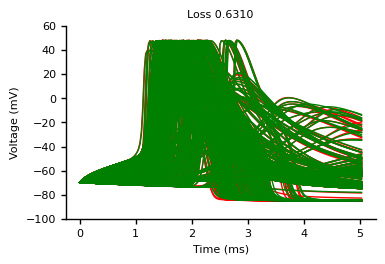

seed 1 ===== Best loss 0.6309865597832593


In [32]:
losses_of_every_starting_point = []
best_traces = []
best_losses = []
all_best_params = []
total_sims = 0
beta = 0.8

for seed in np.arange(1, 2, 25):
    _ = np.random.seed(seed)

    opt_params = init()

    train_losses = []
    grad_norms = []
    
    best_params = opt_params
    best_loss = 100.0
    required_losses = [0.5, 0.1, 0.1, 0.1, 0.1]
    epoch = 0
    
    for iteration in range(1):
        if iteration > 0 and best_loss > required_losses[iteration-1]:
            break

        opt_params = best_params
        optimizer = optax.chain(
            optax.sgd(learning_rate=0.1 / 5.0 ** iteration, momentum=0.9),  # 3.0 / 4.0
        )
        opt_state = optimizer.init(opt_params)
        for epoch in range(500):
            loss_val, grad_val = grad_fn(opt_params)
            total_sims += 1
            if loss_val < best_loss:
                best_loss = loss_val
                best_params = opt_params
                # with open("../results/parameters/opt_params.pkl", "wb") as handle:
                #     pickle.dump(opt_params, handle)

            grad_norm = l2_norm(grad_val)
            grad_val = tree_map(lambda x: x / grad_norm**beta * 1.0, grad_val) 
            grad_norm_corrected = l2_norm(grad_val)
            if epoch % 5 == 0:
                print(f"loss in epoch {epoch}: {loss_val:.4f}, gradient_norm {grad_norm:.4f}, corrected {grad_norm_corrected:.4f}")
            train_losses.append(loss_val)

            if loss_val < required_losses[iteration]:
                break
            
            updates, opt_state = optimizer.update(grad_val, opt_state)
            update_norm = l2_norm(updates)
            opt_params = optax.apply_updates(opt_params, updates)
        
            grad_norms.append(grad_norm)
            epoch += 1

        # with open("../results/parameters/opt_params.pkl", "rb") as handle:
        #     opt_params = pickle.load(handle)
        
        params = transform.forward(opt_params)
        best_trace = jitted_sim(params)
        with mpl.rc_context(fname="../../../.matplotlibrc"):
            fig, ax = plt.subplots(1, 1, figsize=(4, 2.5))
            _ = ax.plot(time_vec, best_trace.T, c="r")
            _ = ax.plot(time_vec, x_o.T, c="g")
            _ = ax.set_title(f"Loss {best_loss:.4f}")
            _ = ax.set_ylim([-100, 60])
            _ = ax.set_xlabel("Time (ms)")
            _ = ax.set_ylabel("Voltage (mV)")
            plt.show()

    if best_loss < desired_loss:
        best_traces.append(best_trace)
        best_losses.append(best_loss)
        all_best_params.append(best_params)
    print(f"seed {seed} ===== Best loss {best_loss}")
    losses_of_every_starting_point.append(train_losses)

In [ ]:
with open("ga_losses.pkl", "rb") as handle:
    ga_losses = pickle.load(handle)

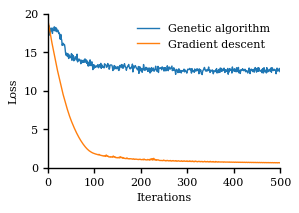

In [ ]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(3, 2))
    _ = ax.plot(ga_losses)
    _ = ax.plot(train_losses)
    _ = ax.set_ylim([0, 20])
    _ = ax.set_ylabel("Loss")
    _ = ax.set_xlabel("Iterations")
    _ = ax.set_xlim([0, 500])
    _ = ax.legend(["Genetic algorithm", "Gradient descent"])
    plt.savefig("performance.png", dpi=400, bbox_inches="tight")

In [ ]:
params = transform.forward(opt_params)

### Apical

In [ ]:
# Apical.
apical_gt = []
apical_found = []
dists = []
num_bins = 11

counter = 0
key = "apical_NaTs2T_gNaTs2T"

dist_bins = np.linspace(100, 1100, num_bins)
dist_bin_assignments = []
for b in apical_inds:
    distance = cell.branch(b).loc(0.0).distance(cell.branch(0).loc(0.0))
    dists.append(distance)
    bin_ = np.digitize(distance, dist_bins)
    dist_bin_assignments.append(bin_)
    cond = np.interp(distance, evals, gt_profiles_apical[key])
    apical_gt.append(cond * bounds[key][1])
    cell.branch(b).set(key, cond * bounds[key][1])

In [ ]:
all_bins_write = [[] for _ in range(num_bins)]
for i, b in enumerate(apical_inds):
    bin_ = dist_bin_assignments[i]
    value = params[counter][key][i]
    apical_found.append(value)
    all_bins_write[bin_].append(value)

In [ ]:
mean_bins = []
for bin_values in all_bins_write:
    mean_bins.append(np.mean(bin_values))

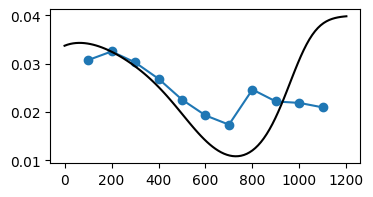

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))

ax.plot(dist_bins, mean_bins)
ax.scatter(dist_bins, mean_bins)
counter = 0
for item in gt_profiles_apical.values():
    if counter < 1:
        _ = ax.plot(evals, item * 0.04, c="k")
    counter += 1

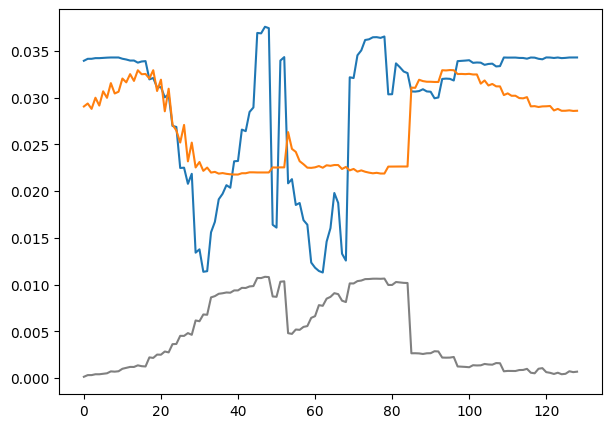

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
_ = ax.plot(apical_gt)
_ = ax.plot(apical_found)
_ = ax.plot(np.asarray(dists) / 100_000, c="gray")

In [ ]:
np.corrcoef(apical_gt, apical_found)[0, 1]

0.5172900775629763

### Axonal

In [ ]:
# Apical.
axonal_gt = []
axonal_found = []

counter = 12
key = "axonal_KPst_gKPst"
for i, b in enumerate(axonal_inds):
    axonal_found.append(params[counter][key][i].item())

for b in axonal_inds:
    distance = cell.branch(b).loc(0.0).distance(cell.branch(0).loc(0.0))
    cond = np.interp(distance, evals, gt_profiles_axonal[key])
    axonal_gt.append(cond * bounds[key][1])
    cell.branch(b).set(key, cond * bounds[key][1])


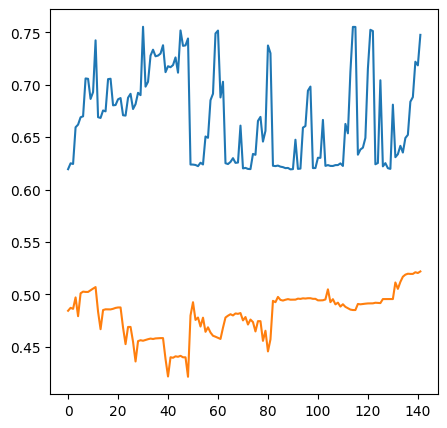

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(axonal_gt)
ax.plot(axonal_found)

In [ ]:
np.corrcoef(axonal_gt, axonal_found)

array([[ 1.        , -0.40902135],
       [-0.40902135,  1.        ]])